In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm, norm
from scipy.optimize import fmin_slsqp
import qvalue as qv

In [3]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Negative')) else False, axis = 1)

new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Positive')) else False, axis = 1)




In [4]:
full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

In [5]:
full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)
for i in full_df['Integrative Cluster'].unique():
    if type(i) == str:
        full_df[f'Intclust {i} or not'] = full_df.apply(lambda row: i if (row['Integrative Cluster'] == i) else 'Not', axis = 1)


In [6]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import qvalue as qv

clusterframes = {}


for i in full_df['Integrative Cluster'].unique():
    if type(i) == str:
        df_cluster = pd.DataFrame(index=pca_per_pathway.columns) 
        pvaluelist = []
        for pathway in df_cluster.index:
            results = ols("Q(pathway) ~ C(Q(f'Intclust {i} or not'))", data=full_df).fit()
            table = sm.stats.anova_lm(results, typ=2)
            pvalue = table['PR(>F)'][0]
            pvaluelist.append(pvalue)
    
        df_cluster['p-values'] = pvaluelist
        qv.qvalues(df_cluster, 'p-values', 'qvalues')
        print(i)
        clusterframes[i] = df_cluster

4ER+
9
7
3
8
10
1
2
5
4ER-
6


In [56]:
significant_pathways = {}
def failures_of_null_anova(cluster, my_xa, my_xb, iterations=10000):
    pvalues = clusterframes[cluster]['p-values'].tolist()
    pvalues = [0.999 if x == 1.0 else x for x in pvalues] ##pathways with p-val 1 gave error as range would be to inf
    pvalues = sorted(pvalues)
    z_scores = norm.ppf(pvalues)
    print(z_scores)
    xa = np.percentile(z_scores, my_xa)
    xb = np.percentile(z_scores, my_xb)
    print(f'Quantiles calculated: {xa}, {xb}')


    trunc_z = z_scores[z_scores>xa]
    trunc_z = trunc_z[trunc_z<xb]

    def func(p, r, xa, xb):
        return truncnorm.nnlf(p, r)

    def constraint(p, r, xa, xb):
        a, b, loc, scale = p
        return np.array([a*scale + loc - xa, b*scale + loc - xb])

    loc_guess = np.median(z_scores)
    scale_guess = np.std(z_scores)
    a_guess = (xa - loc_guess)/scale_guess
    b_guess = (xb - loc_guess)/scale_guess
    p0 = [a_guess, b_guess, loc_guess, scale_guess]

    par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(trunc_z, xa, xb), iter=iterations)
    print(par)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.hist(z_scores, bins=50, density=True)
    ax.plot(z_scores, truncnorm.pdf(z_scores, par[0], par[1], par[2], par[3]), 'r-', lw=5, alpha=0.6, label='truncnorm pdf')
    ax.plot(z_scores, norm.pdf(z_scores, par[2], par[3]), 'g-', lw=5, alpha=0.6, label='norm pdf')
    ax.plot(z_scores, norm.sf(abs(z_scores-par[2]), 0, par[3]), 'y-', lw=5, alpha=0.6, label='norm sf')
    ax.legend(loc='best')
    plt.show()

    p_vals = norm.sf(abs(z_scores-par[2]), 0, par[3])

    plt.figure(figsize=(15, 10))
    plt.hist(p_vals, bins=30, density=True)
    plt.show()
    #print(pvalues[:10])
    print(p_vals[:20])
    sig_pathways = p_vals[p_vals < 0.001].size
    significant_pathways[cluster] = sig_pathways
    print(f'number of pathways with p < 0.001: {p_vals[p_vals < 0.001].size}')
    
    
    ##let's add to clusterframes
    clusterframes[cluster]['adjusted p-value'] = p_vals
    qv.qvalues(clusterframes[cluster], 'adjusted p-value', 'adjusted q-values')
    
    ##and log fold change
    clusterframes[cluster]['log adjusted p-value'] = -np.log10(clusterframes[cluster]['adjusted p-value'])
    clusterframes[cluster][f'cluster {cluster} log adjusted q-value'] = -np.log10(clusterframes[cluster]['adjusted q-values'])

In [57]:
clusterframes['7']

,p-values,qvalues,adjusted p-value,adjusted q-values,log adjusted p-value,log adjusted q-value,cluster Cluster 9 q-values log adjusted q-value
Ion channel transport,1.640604e-38,3.402613e-35,3.651878e-10,7.218217e-07,9.437484,6.141570,6.141570
Cytosolic iron-sulfur cluster assembly,1.824016e-37,1.891505e-34,6.960673e-10,7.218217e-07,9.157349,6.141570,6.141570
Activation of NMDA receptors and postsynaptic events,8.506606e-32,4.992945e-29,2.248479e-08,9.508135e-06,7.648111,5.021905,5.021905
Ubiquinol biosynthesis,9.629594e-32,4.992945e-29,2.323527e-08,9.508135e-06,7.633852,5.021905,5.021905
Post NMDA receptor activation events,1.584346e-31,6.297383e-29,2.650865e-08,9.508135e-06,7.576612,5.021905,5.021905
...,...,...,...,...,...,...,...
Sodium/Proton exchangers,2.223424e-08,7.061840e-08,4.991257e-01,4.996336e-01,0.301790,0.472995,0.301348
FGFR2 ligand binding and activation,2.048277e-02,2.964498e-02,4.994861e-01,4.996336e-01,0.301477,0.472839,0.301348
Synthesis of Lipoxins (LX),6.492925e-02,8.522992e-02,4.995165e-01,4.996336e-01,0.301450,0.472351,0.301348
Uptake and function of anthrax toxins,6.424459e-07,1.661388e-06,4.995835e-01,4.996336e-01,0.301392,0.471608,0.301348


[-13.9119998  -13.27006612 -13.16634135 ...   2.88812157   3.04851915
   3.08715614]
Quantiles calculated: -3.3866202307667503, 3.0791466944178243
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2255.3083333272084
            Iterations: 267
            Function evaluations: 2143
            Gradient evaluations: 267
[-1.33557563  2.6023572  -1.19371316  1.64191905]


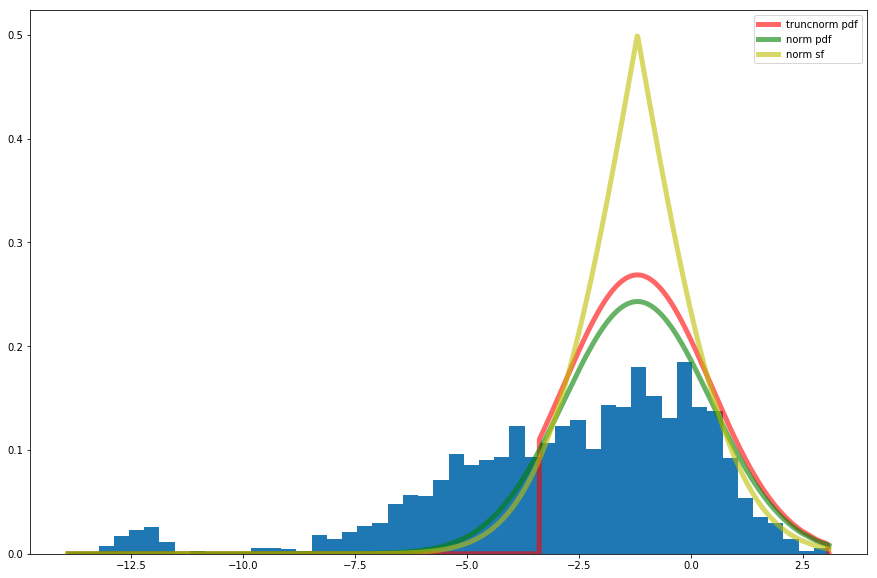

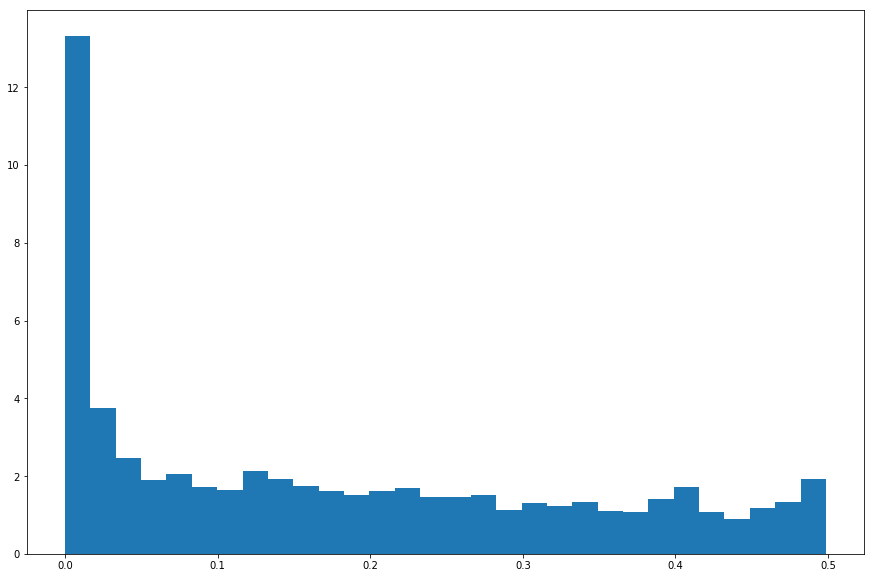

[4.74204115e-15 9.54468534e-14 1.52863170e-13 1.61436777e-13
 2.97758193e-13 2.97758935e-13 4.14612917e-13 5.41070164e-13
 7.45772463e-13 8.12203543e-13 9.97888225e-13 1.28407213e-12
 1.29480052e-12 1.32229389e-12 1.38061990e-12 1.42636402e-12
 1.92372313e-12 1.92595265e-12 1.92595677e-12 2.36338418e-12]
number of pathways with p < 0.001: 215


In [58]:
failures_of_null_anova('1', 35, 99.99)

[-6.84631661 -6.59458776 -6.57521133 ...  2.57862542  2.68407125
  2.84892587]
Quantiles calculated: -1.9487227015155724, 0.3343508380528847
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 929.6904342358471
            Iterations: 74
            Function evaluations: 554
            Gradient evaluations: 74
[-0.92896097  1.03500486 -0.86882295  1.16248129]


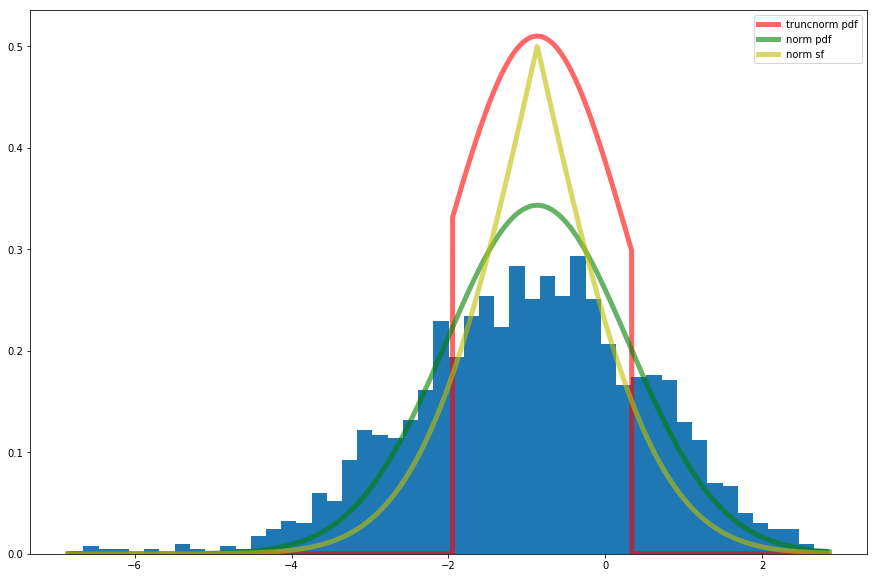

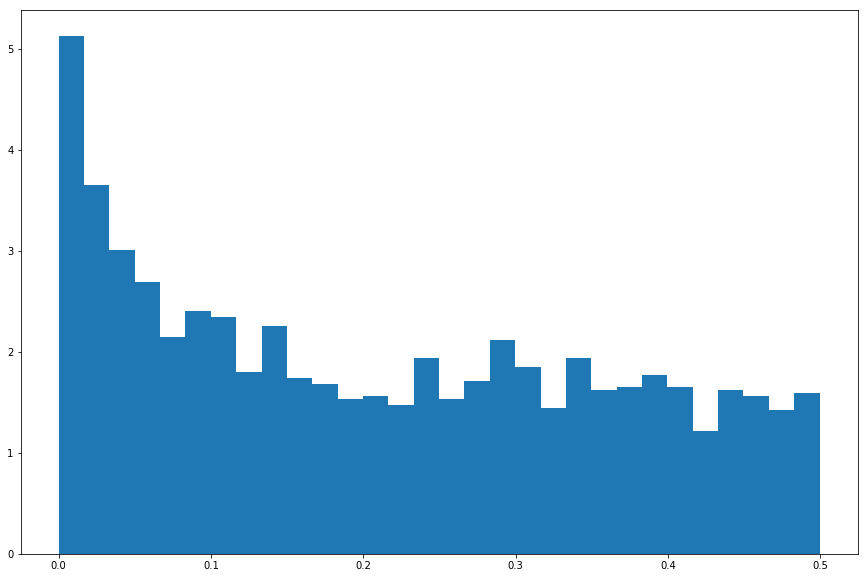

[1.35905311e-07 4.20792665e-07 4.58176418e-07 5.08076572e-07
 7.64303163e-07 1.34156370e-06 2.10555719e-06 3.08142443e-06
 8.40832468e-06 1.11855878e-05 3.74407303e-05 4.91854887e-05
 5.04155040e-05 5.20847704e-05 1.15228398e-04 1.15228503e-04
 2.01110871e-04 3.36322998e-04 3.36324196e-04 3.75252044e-04]
number of pathways with p < 0.001: 24


In [59]:
failures_of_null_anova('2', 25, 80)

[-14.83838977 -14.73374098 -14.67363221 ...   2.56879163   2.59389826
   2.59581911]
Quantiles calculated: -3.781479875312232, 1.7630456657758322
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2008.9868004777372
            Iterations: 129
            Function evaluations: 996
            Gradient evaluations: 129
[-0.8249283   1.80725401 -2.04382058  2.10643675]


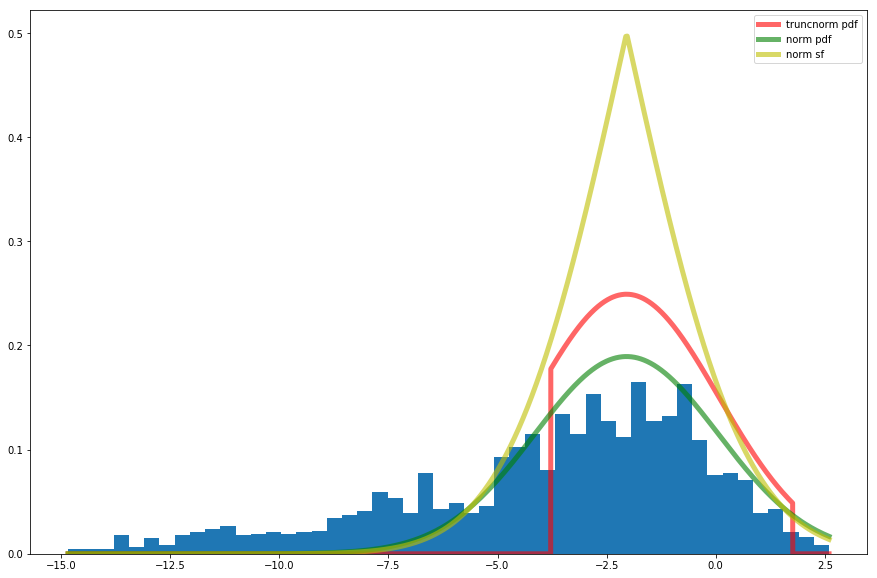

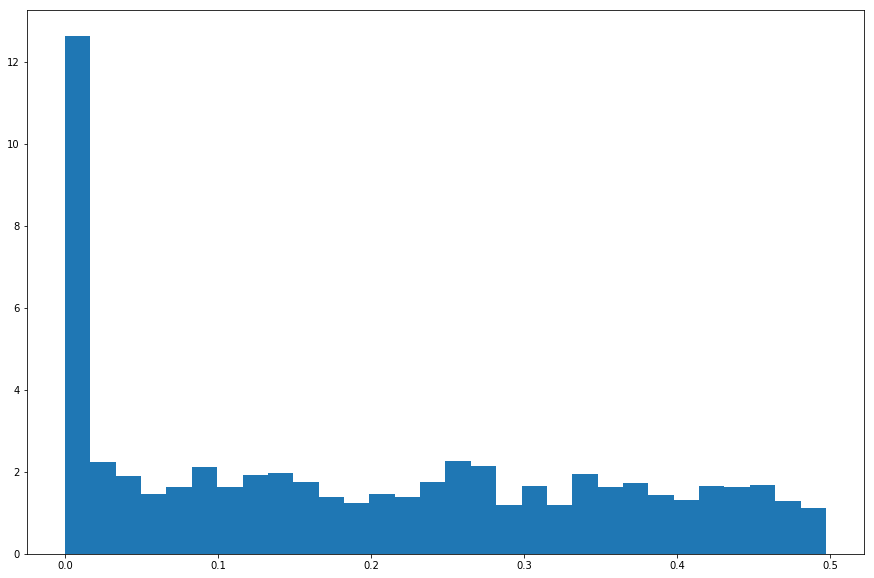

[6.23680076e-10 8.48932533e-10 1.01231758e-09 2.28322248e-09
 2.29873812e-09 2.79401185e-09 7.83843179e-09 9.11253540e-09
 9.11257877e-09 1.50839051e-08 1.54352615e-08 1.54607355e-08
 1.64338892e-08 1.69524219e-08 1.80320687e-08 1.86905029e-08
 2.18007295e-08 2.20682770e-08 2.22591378e-08 2.79041705e-08]
number of pathways with p < 0.001: 223


In [60]:
failures_of_null_anova('3', 40, 99, iterations=100000)

[-13.93086523 -12.3419182  -12.27722993 ...   2.36156958   2.43890359
   2.66449199]
Quantiles calculated: -4.327214793113503, 2.3524708098658613
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2442.6711492945687
            Iterations: 156
            Function evaluations: 1230
            Gradient evaluations: 156
[-1.11199312  1.94249663 -1.89546186  2.18684171]


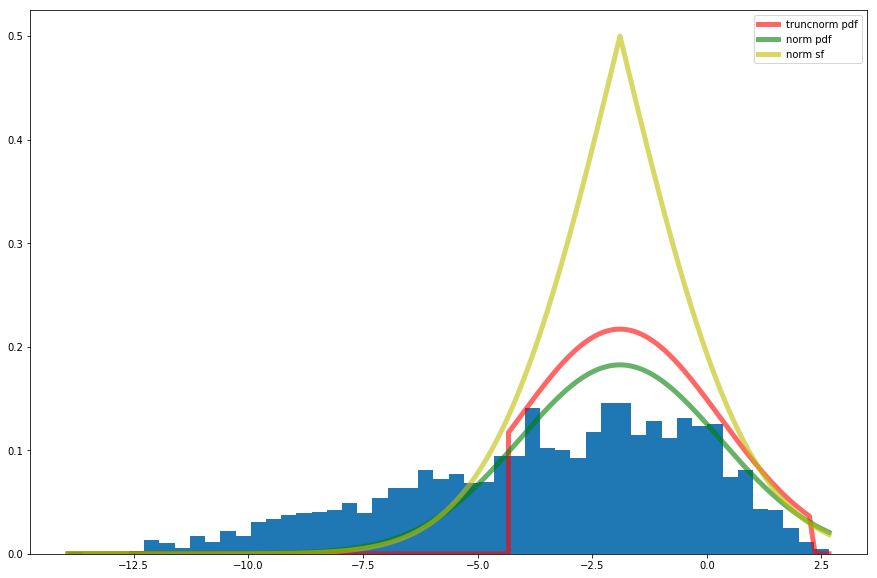

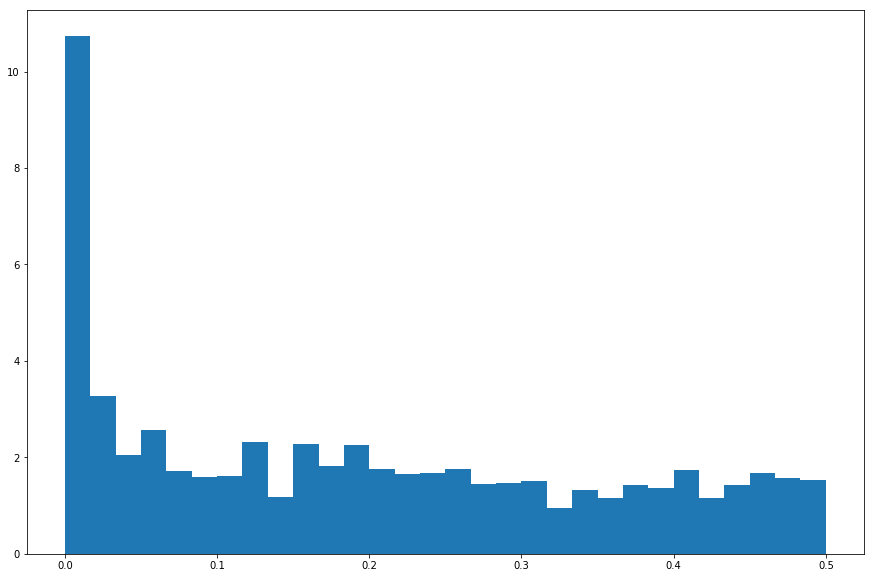

[1.86104305e-08 8.89823871e-07 1.03034415e-06 1.13599791e-06
 1.22607769e-06 1.23025272e-06 1.53969186e-06 1.56294997e-06
 1.90461091e-06 2.01362390e-06 2.04341016e-06 2.13696744e-06
 2.36111961e-06 2.42335879e-06 2.73473393e-06 3.18241491e-06
 3.83516216e-06 3.96911735e-06 4.05962828e-06 4.88912494e-06]
number of pathways with p < 0.001: 164


In [61]:
failures_of_null_anova('4ER-', 35, 99.9)

[-17.96216636 -16.73041369 -16.4718797  ...   2.74006575   2.74036923
   3.08908026]
Quantiles calculated: -4.724111263333868, 1.369161947331994
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1981.6688519263168
            Iterations: 321
            Function evaluations: 2543
            Gradient evaluations: 321
[-1.11152678  1.53667634 -2.16658979  2.30090856]


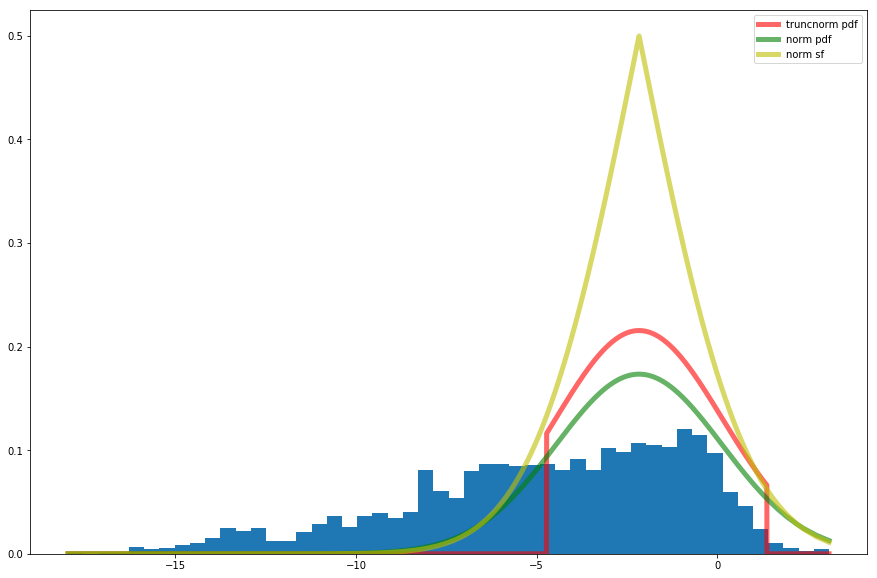

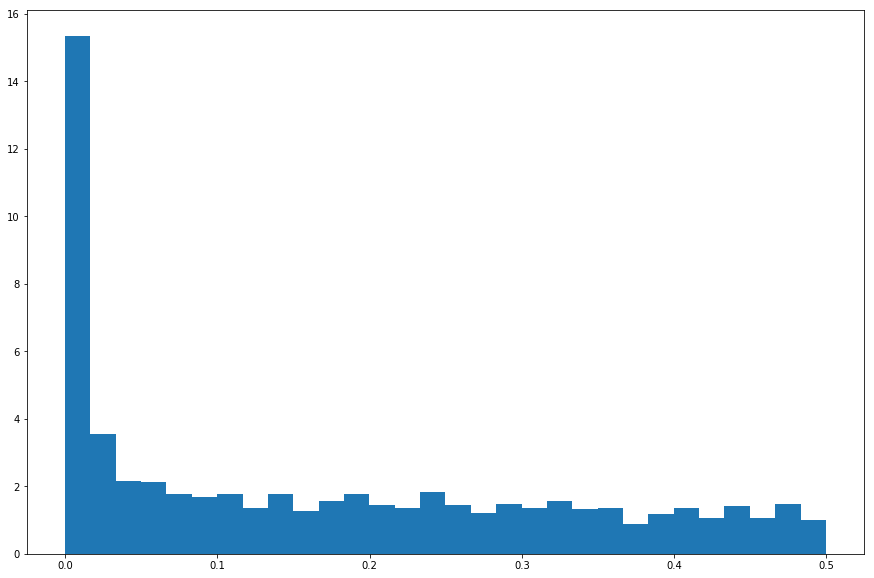

[3.32618947e-12 1.22901169e-10 2.52995361e-10 4.41582255e-10
 4.77589168e-10 4.78425059e-10 6.57353999e-10 8.33198513e-10
 8.49790159e-10 1.34922604e-09 1.77544821e-09 2.13635314e-09
 2.48463280e-09 4.42204280e-09 7.03672347e-09 7.13014695e-09
 8.81382096e-09 9.52028321e-09 1.45434939e-08 1.87283348e-08]
number of pathways with p < 0.001: 288


In [62]:
failures_of_null_anova('4ER+', 45, 99)

[-19.17431748 -18.97033885 -18.24982862 ...   2.78656516   2.90959138
   3.08069778]
Quantiles calculated: -4.640139573741501, 1.7418364317210873
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2918.014266703949
            Iterations: 92
            Function evaluations: 689
            Gradient evaluations: 92
[-1.57737078  1.77409807 -1.63645882  1.90423253]


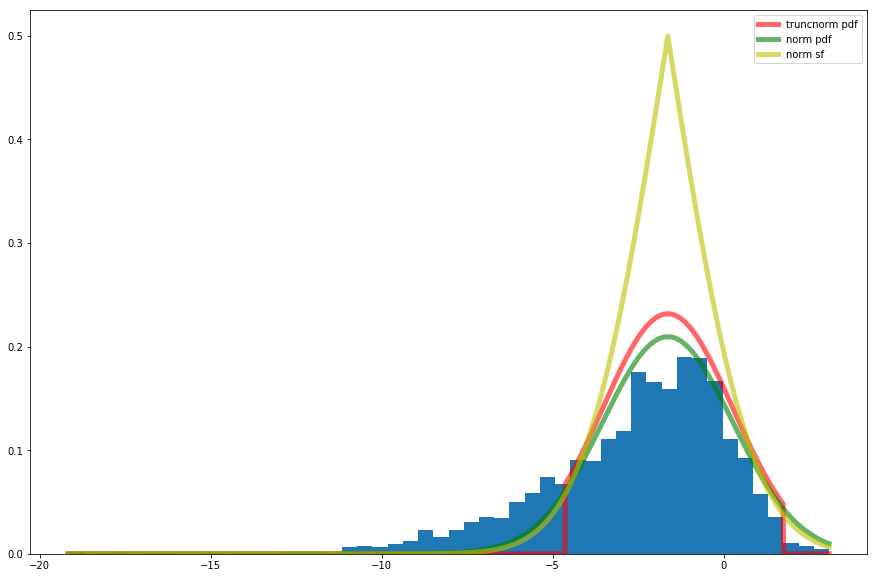

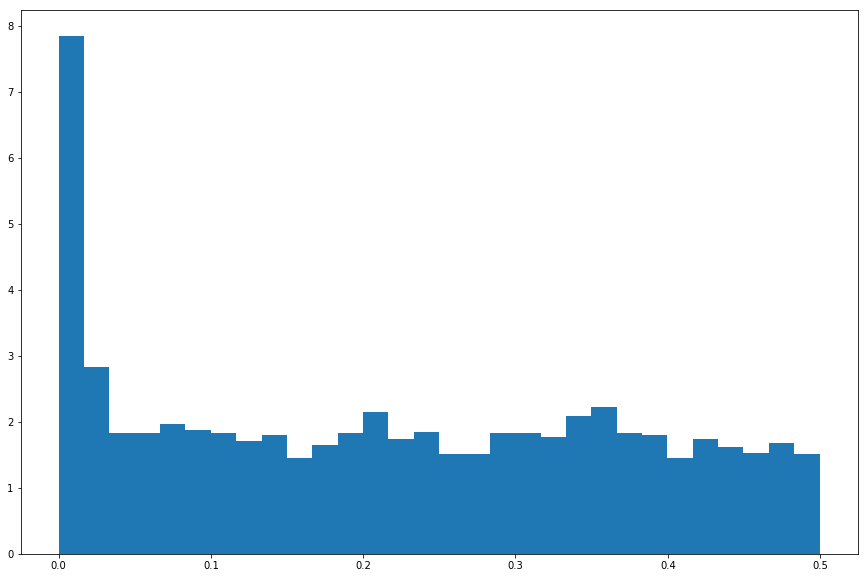

[1.63160558e-20 4.40093682e-20 1.33745972e-18 5.45048343e-17
 6.06500368e-17 6.89238388e-16 1.53524129e-14 1.78169725e-12
 1.62103457e-11 3.31939353e-10 1.31639150e-09 1.71505933e-09
 2.04025898e-09 7.85828922e-09 8.67311204e-09 3.52563322e-08
 6.15884600e-08 8.79179172e-08 2.94881739e-07 6.01772997e-07]
number of pathways with p < 0.001: 117


In [63]:
failures_of_null_anova('5', 20, 99)

[-33.62247858 -16.41150422  -9.77234282 ...   3.21698071   3.21743531
   3.21760124]
Quantiles calculated: -5.564399174467789, 1.9441879585875987
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3792.2211183505865
            Iterations: 7
            Function evaluations: 48
            Gradient evaluations: 7
[-2.32482848  1.75594215 -1.28673233  1.83999244]


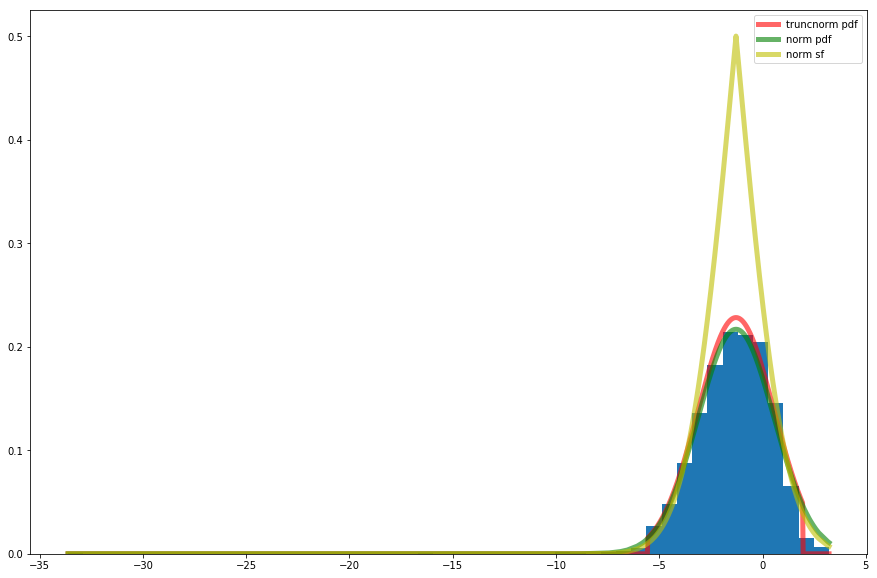

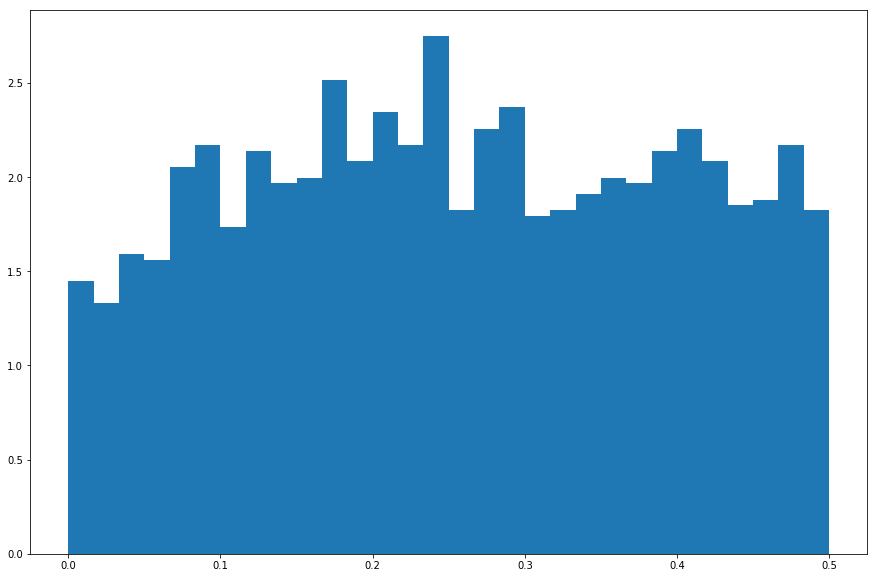

[1.95375739e-69 1.01735912e-16 1.99633294e-06 4.07032423e-06
 2.31672000e-05 3.55432660e-04 4.26960776e-04 1.08052837e-03
 1.11334318e-03 1.18590451e-03 2.13557321e-03 4.59944918e-03
 4.69572209e-03 6.53983025e-03 6.84980510e-03 6.98885930e-03
 7.19311299e-03 7.47258602e-03 7.85323574e-03 9.20055499e-03]
number of pathways with p < 0.001: 7


In [64]:
failures_of_null_anova('6', 1, 99)

[-12.92433509 -12.73774146 -11.67546537 ...   2.8660079    2.93598415
   3.2522174 ]
Quantiles calculated: -2.69715218026396, 3.18666225035813
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1211.184279918399
            Iterations: 137
            Function evaluations: 1048
            Gradient evaluations: 137
[-0.5151523   2.73202689 -1.76370799  1.81197713]


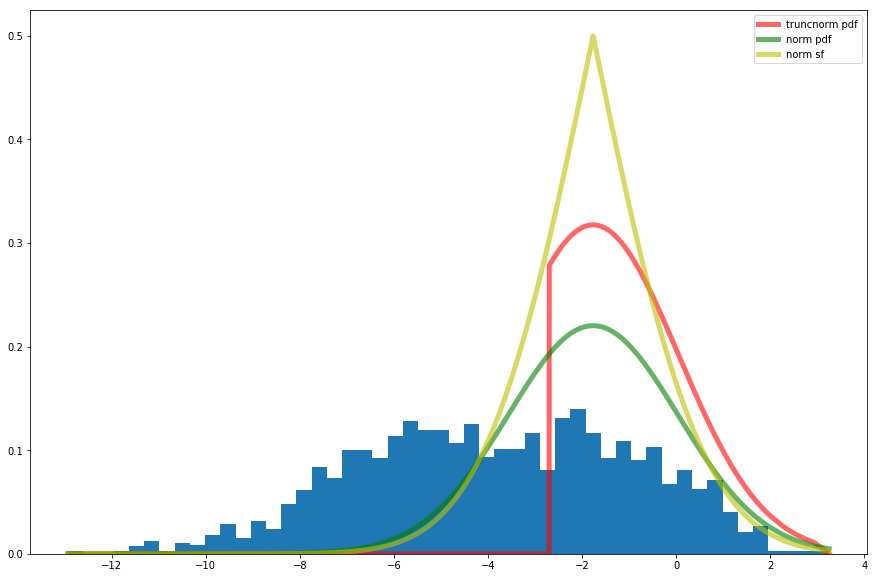

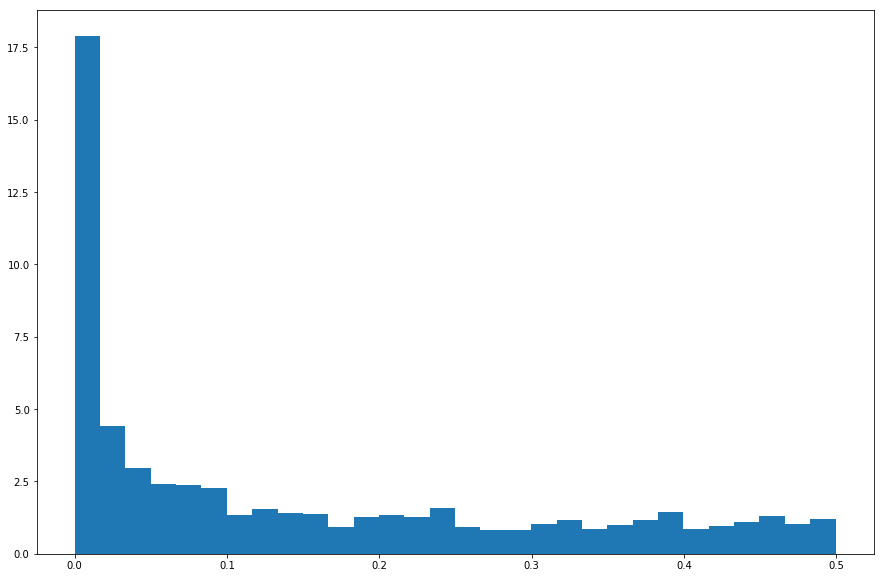

[3.65187844e-10 6.96067254e-10 2.24847945e-08 2.32352660e-08
 2.65086462e-08 2.75066592e-08 3.40846700e-08 3.72000938e-08
 6.58771525e-08 7.33493959e-08 7.34032674e-08 8.61471194e-08
 9.67843654e-08 9.70171233e-08 1.29414893e-07 1.52516097e-07
 1.59685086e-07 2.27363223e-07 2.41583519e-07 6.26211628e-07]
number of pathways with p < 0.001: 246


In [65]:
failures_of_null_anova('7', 61, 99.99)

[-24.44703769 -19.95758085 -17.62577911 ...   2.65103978   3.34448305
   3.34621721]
Quantiles calculated: -6.361630402125722, 1.3578219383379848
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2563.774672880685
            Iterations: 102
            Function evaluations: 746
            Gradient evaluations: 102
[-0.96214603  1.22509851 -2.96592393  3.52930465]


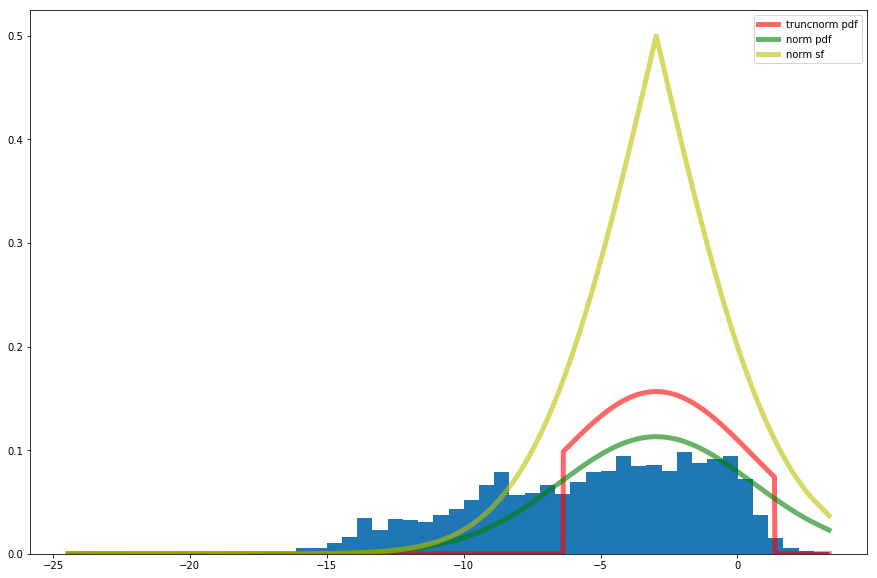

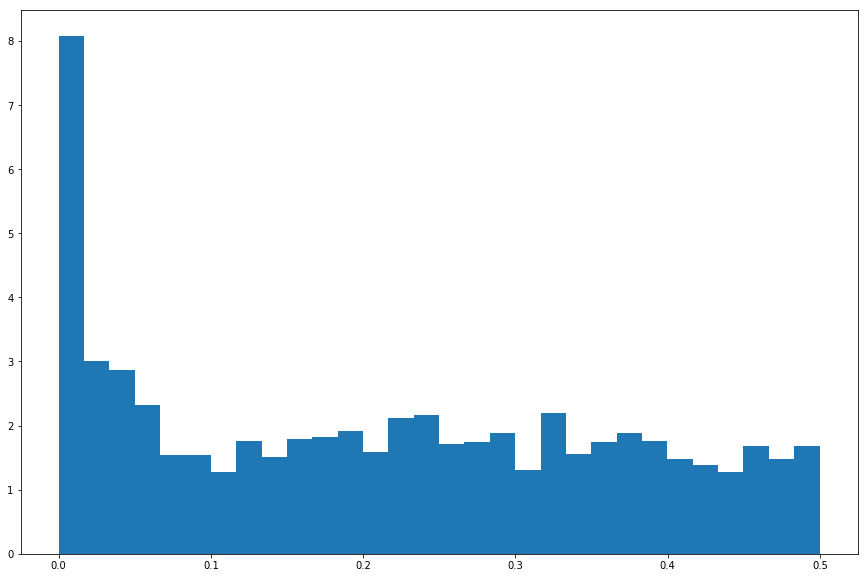

[5.77027271e-10 7.38033315e-07 1.63534042e-05 3.66335215e-05
 5.03579806e-05 7.97894034e-05 8.07531410e-05 1.07531682e-04
 1.22346270e-04 1.48838139e-04 1.50804619e-04 1.53120542e-04
 1.63796885e-04 1.89505945e-04 2.23634113e-04 2.29754255e-04
 2.55711872e-04 2.89328743e-04 2.99696436e-04 3.13985434e-04]
number of pathways with p < 0.001: 52


In [66]:
failures_of_null_anova('8', 38, 99)

[-17.40250118 -17.1360966  -17.13605926 ...   2.93432457   3.00675783
   3.22513698]
Quantiles calculated: -3.747773078817006, 2.931699477980507
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2632.848303260692
            Iterations: 52
            Function evaluations: 383
            Gradient evaluations: 52
[-1.43025026  2.66524524 -1.41513289  1.63093148]


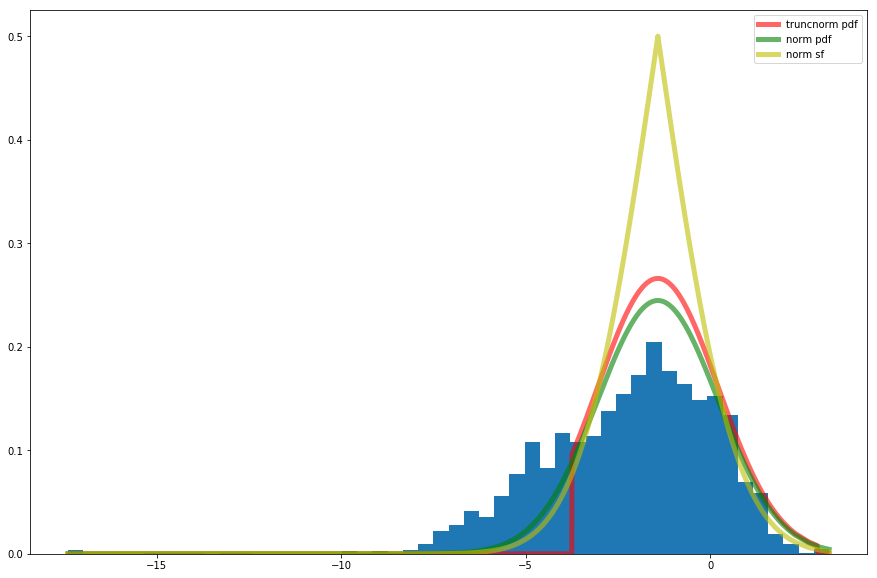

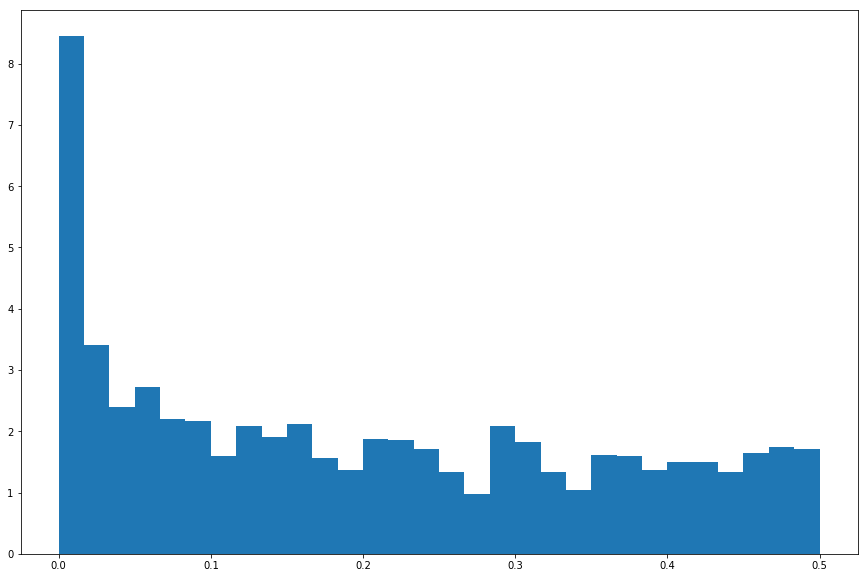

[5.48623765e-23 2.72914548e-22 2.72975420e-22 2.84414636e-17
 1.45745719e-16 2.21669225e-15 5.00792208e-15 5.67028650e-13
 1.11724076e-12 1.10794289e-07 1.44080186e-07 1.01237974e-06
 1.26043386e-06 1.49418292e-06 6.50233156e-06 1.69986261e-05
 2.86862886e-05 3.35045688e-05 3.59391630e-05 3.74941795e-05]
number of pathways with p < 0.001: 87


In [67]:
failures_of_null_anova('9', 25, 99.9)

[-34.66291375 -34.66291179 -33.31015597 ...   2.28558475   2.6496367
   2.70303907]
Quantiles calculated: -11.727118245400064, 2.7019320354627903
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3529.824314514408
            Iterations: 129
            Function evaluations: 980
            Gradient evaluations: 129
[-1.37690872  1.60442589 -5.06316141  4.83979564]


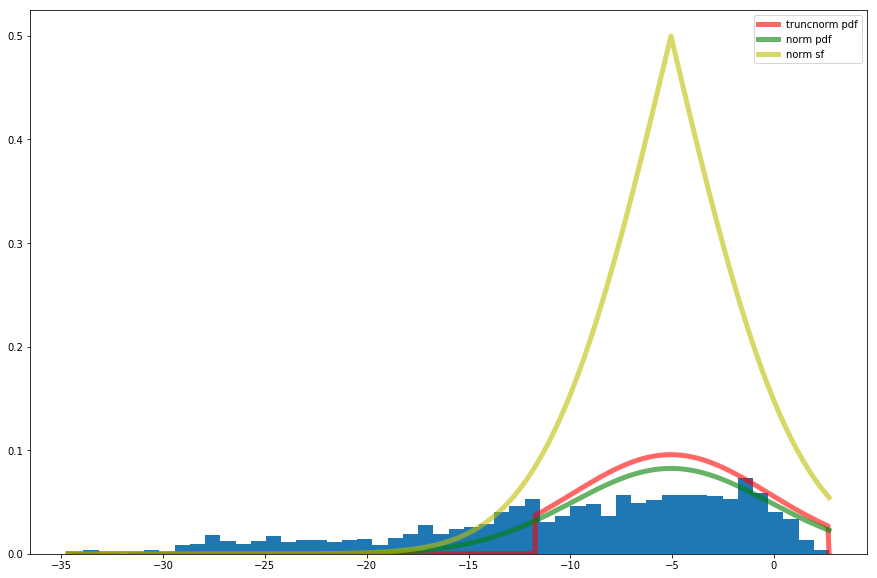

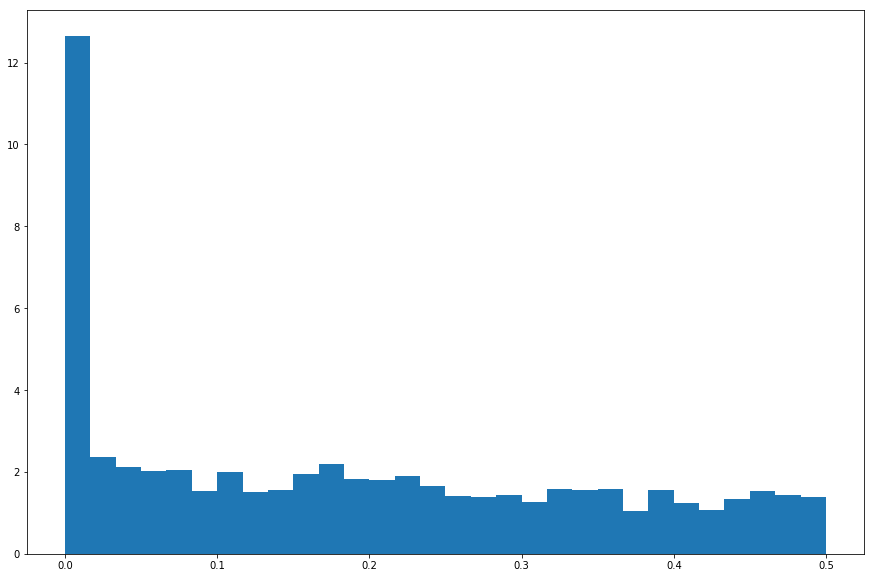

[4.80038877e-10 4.80040092e-10 2.66700023e-09 2.66700925e-09
 2.66701198e-09 2.66701502e-09 2.66701939e-09 3.54462842e-09
 2.36158947e-08 2.73232460e-08 4.84455382e-08 6.71981603e-08
 8.30160918e-08 8.94112547e-08 1.03434280e-07 1.71444726e-07
 1.74313185e-07 2.21864706e-07 2.43173327e-07 2.79516311e-07]
number of pathways with p < 0.001: 255


In [68]:
failures_of_null_anova('10', 35, 99.999)

In [69]:
gsea_df = pd.read_csv('../exp/GSEA_qvalues.csv', index_col = 0)
gsea_df_counts = {}

for column in gsea_df.columns:
    columnshape = gsea_df[gsea_df[column] >= 3].shape[0]
    gsea_df_counts[column] = columnshape

adjusted_q_counts = {}
for cluster in clusterframes:
    columnshape = clusterframes[cluster][clusterframes[cluster]['adjusted q-values'] <= 0.001].shape[0]
    adjusted_q_counts[cluster] = columnshape
    
wall_df = pd.read_csv('../exp/pathway_qvalues.csv', index_col = 0)
wal_df = wall_df.loc[:, wall_df.columns.str.endswith('q-values')]
new_name = {}
for i in wal_df.columns:
    new_i = i.strip('Cluster q-values')
    new_name[i] = new_i
    
wal_df = wal_df.rename(columns =new_name)

wall_df_counts = {}
for column in wal_df.columns:
    columnshape = wal_df[wal_df[column] >= 3].shape[0]
    #print(columnshape)
    wall_df_counts[column] = columnshape

wall_df_counts['4ER-'] = wall_df_counts.pop('4ER')
print(wall_df_counts)
print(adjusted_q_counts)

{'1': 828, '10': 1615, '2': 78, '3': 1048, '4ER+': 1303, '5': 839, '6': 290, '7': 1126, '8': 1354, '9': 723, '4ER-': 1029}
{'4ER+': 174, '9': 15, '7': 83, '3': 150, '8': 2, '10': 170, '1': 114, '2': 8, '5': 44, '4ER-': 29, '6': 2}


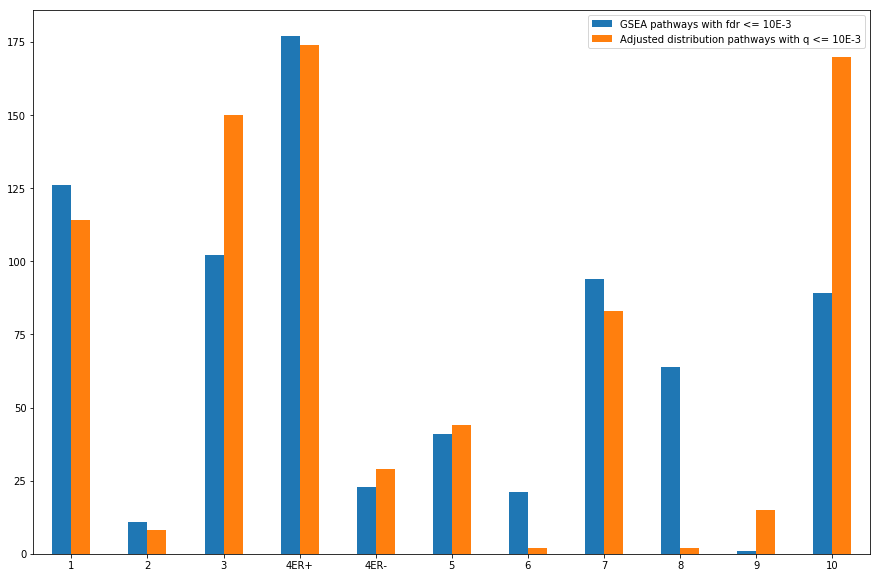

In [70]:
full_df = pd.DataFrame({'GSEA pathways with fdr <= 10E-3': gsea_df_counts, 
                        #'Mann whitney pathways with q-value <= 10E-3': significant_pathways,
                        #'Wall pathways with q <= 10E-3': wall_df_counts,
                        'Adjusted distribution pathways with q <= 10E-3': adjusted_q_counts})
ax = full_df.plot.bar(rot=0, figsize=(15, 10))
plt.show()

In [71]:
clusterframes['1']

,p-values,qvalues,adjusted p-value,adjusted q-values,log adjusted p-value,log adjusted q-value,cluster Cluster 9 q-values log adjusted q-value,cluster 1 log adjusted q-value
RMTs methylate histone arginines,2.678034e-44,5.554242e-41,4.742041e-15,9.834993e-12,14.324035,11.007226,11.007226,11.007226
HDMs demethylate histones,1.726380e-40,1.790256e-37,9.544685e-14,8.370497e-11,13.020238,10.077249,10.077249,10.077249
Senescence-Associated Secretory Phenotype (SASP),6.854062e-40,4.169670e-37,1.528632e-13,8.370497e-11,12.815697,10.077249,10.077249,10.077249
Cellular Senescence,8.041793e-40,4.169670e-37,1.614368e-13,8.370497e-11,12.791998,10.077249,10.077249,10.077249
Nucleosome assembly,4.833426e-39,1.670767e-36,2.977582e-13,1.029253e-10,12.526136,9.987478,9.987478,9.987478
...,...,...,...,...,...,...,...,...
ERK/MAPK targets,5.647747e-02,9.918228e-02,4.982286e-01,4.986452e-01,0.302571,0.347610,0.453235,0.302208
Electric Transmission Across Gap Junctions,5.098218e-04,1.411709e-03,4.983415e-01,4.986452e-01,0.302473,0.347610,0.453856,0.302208
MET activates RAS signaling,2.715671e-02,5.186281e-02,4.985252e-01,4.986452e-01,0.302313,0.347310,0.453856,0.302208
Regulation of gene expression in early pancreatic precursor cells,2.113545e-01,3.033558e-01,4.985255e-01,4.986452e-01,0.302313,0.347610,0.453856,0.302208


In [72]:
full_clusterframe = pd.DataFrame(index=clusterframes['1'].index)
full_clusterframe
for i in clusterframes:
    print(type(i))
    series = clusterframes[i][f'cluster {i} log adjusted q-value']
    full_clusterframe = pd.concat([full_clusterframe, series.reindex(full_clusterframe.index)], axis=1)

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [73]:
full_clusterframe

,cluster 4ER+ log adjusted q-value,cluster 9 log adjusted q-value,cluster 7 log adjusted q-value,cluster 3 log adjusted q-value,cluster 8 log adjusted q-value,cluster 10 log adjusted q-value,cluster 1 log adjusted q-value,cluster 2 log adjusted q-value,cluster 5 log adjusted q-value,cluster 4ER- log adjusted q-value,cluster 6 log adjusted q-value
RMTs methylate histone arginines,1.013195,0.335133,0.338467,0.420620,0.412965,0.521410,11.007226,0.455863,0.328151,0.463741,0.305882
HDMs demethylate histones,0.687528,0.532431,0.361724,0.346801,0.414617,0.374829,10.077249,0.462853,0.340697,0.311009,0.305882
Senescence-Associated Secretory Phenotype (SASP),1.122875,0.408157,0.402903,0.350387,0.372203,0.519281,10.077249,0.327534,0.377901,0.302189,0.305882
Cellular Senescence,1.534567,0.362320,0.481708,0.362877,0.379135,0.317770,10.077249,0.364342,0.303202,0.324785,0.305882
Nucleosome assembly,1.804226,0.510312,0.676536,1.132033,0.517522,0.430678,9.987478,0.574503,0.539732,0.541404,0.305882
...,...,...,...,...,...,...,...,...,...,...,...
ERK/MAPK targets,0.426177,0.535717,0.366878,0.334731,0.308213,0.476949,0.302208,0.370370,0.306516,0.413038,0.305882
Electric Transmission Across Gap Junctions,0.511605,0.301643,2.109360,0.323252,0.308213,0.308970,0.302208,0.319658,0.306111,0.454061,0.305882
MET activates RAS signaling,0.549408,0.335630,0.319613,0.488536,0.412002,0.317770,0.302208,0.416013,0.316702,0.389465,0.303047
Regulation of gene expression in early pancreatic precursor cells,0.311763,0.393469,2.109360,0.307045,0.422721,0.647266,0.302208,0.366367,0.491735,0.510566,0.305882


In [75]:
full_clusterframe.to_csv('../exp/adjusted_distributions_intclusts.csv')